# Modeling Process

This notebook goes through our entire process for data cleaning, finding features, modeling, and evaluation.

In the first step, we looked at what data columns we had so that we were aware of what we had. This process was done in another notebook called firstmodel. In that notebook, we looked for missing values in each column. The basement_sqft column had an object data type and on further inspection, there was one question mark in it. That value was changed to a null and then the whole column was made a float. Then, the null value was replaced with the mean of the whole column. 

Next, I looked at a histogram of the price and saw that it was very skewed. I decided to drop 20 of the highest priced homes which was about 0.1% of the data.

The null values in the next columns, yr_renovated, waterfront, and view, were replaced with zeros so that they would effect the model. I decided to make a new column called reno that is a zero or one if the house had been renovated or not.

After that, I made three new columns called day, month, and year from the date column and then dropped the date. I also had to make those columns into floats. I also used the month column to make another categorical feature called season.

Next up was a little bit of feature engineering. In the notebook called interactions, I looked at many combinations of features by multiplying or dividing them and tranformations of the data. I found a few features that were promising like multiplying sqft_living times grade and squaring the number of bathrooms.

I added them to one dataframe and then saved it as cleaed_df so that the group could work from it.

In this notebook, I read in that cleaned dataframe as well as two others. One contains distances from the closest whole foods and the other contains the median income for each zipcode. I combined these into one dataframe and then dropped the id column. From there, I added a few more engineered features after digging deeper into some interactions with the new whole foods and income data.

Finally, I dropped 200 more (1%) of the highest priced homes to get a better distrobution.

The rest of this notebook is the modeling and evaluation portion. I wrote a few functions that would fit different models and transform the features in many different ways. I settled on a standard transformation and a normal linear regression for simplicity and model performance.

The model is scored based on the root mean square error of the train and test sets,
a cross validation, and the error of the test set using 10 price bins from 81 thousand dollars to 2 million dollars. Most error is between 85 thousand and 2 million. The error in all other bins is around 30 thousand dollars down to 5.5 thousand dollars for one bin.

Additionally, the coefficient importance was plotted to be sure that all features were comtributing sufficiently to the model.


### Feature Selection

I looked at many interactions between variables that are shown in the interactions notebook. I picked the best ones and then dropped the individual features to prevent colinearity. I also made a barplot of the weights of each feature and took out the very lowest ones.

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


Here, I am reading in all of the data that we found from external sources and joining them all together.

In [2]:
#read in the cleaned df and set col index

df = pd.read_csv('cleaned_df',index_col=0)
df_med = pd.read_csv('mediandf.csv',index_col=0)
df_wf = pd.read_csv('Closest_WF',index_col=0)

I dropped the id column and then make all of the engineered features here.

In [3]:
#drop id col
df.drop('id',axis=1,inplace=True)
df = df.join(df_med)
df = df.join(df_wf)
#waterfront time grade
df['sqrt_long_times_WF'] = np.sqrt(abs(df['long'] * df['Closest_WF']))
df['yr_built_times_grade'] = df['yr_built'] * df['grade']
df['water_times_grade'] = df['waterfront'] * df['grade']
df['sqrt_sqft_above'] = np.sqrt(abs(df['sqft_above']))
df['int_WFlivgrd'] = np.sqrt(abs(df['sqft_living_times_grade'])) * np.sqrt(abs(df['Closest_WF']))
# ('sqft_living_times_grade', 'Closest_WF', 0.798)

I decided to drop 200 more of the most expensive houses to get a more normal price distribution.

In [4]:
drop_rows = df['price'].sort_values(ascending=False)[:200]
df.drop(drop_rows.index,axis=0,inplace=True)

In [5]:
#import model packages
#fir the basic model
#for testing
from sklearn.model_selection import cross_val_score
#adding some more model testing
from sklearn.model_selection import KFold
#train test split
from sklearn.model_selection import train_test_split
#scoring
#feature elimination
from sklearn.feature_selection import RFE
#scoring
from sklearn.metrics import mean_squared_error
#trying some polynomial features



This is where I set which categorical and continuous features to use in the model.

In [6]:
#defining which values are categorical or not
#'bedrooms','floors','condition','zipcode','season','view'
categoricals = ['bedrooms','waterfront','view','condition','reno','median_by_zip']

continuous = ['price','sqft_lot','sqrt_sqft_above','sqft_basement','lat','long',
              'sqft_living15','sqft_lot15',
              'bathrooms_sq','int_WFlivgrd']

#base model
# categoricals = ['bedrooms','bathrooms_sq','waterfront','floors','view','grade','condition','zipcode','reno']
# continuous = ['price','sqft_living_sq','sqft_lot','sqft_above','sqft_basement','yr_built','lat','long','sqft_living15','sqft_lot15','month','year','yr_renovated']



df_cont = df[continuous]


In [7]:
#compare different scalers
#im going to make a function to take the output of scalers and git back the score
#then do it for multiple scalers

Now, one hot encode the categorical features and combine them with the continuous ones.

In [8]:
#one hot encode the categoricals
df_ohe = pd.get_dummies(df[categoricals])
#combine the data into one frame
preprocessed = pd.concat([df_cont, df_ohe],axis=1)
#make feature set by dropping price
X = preprocessed.drop('price',axis=1)

#make target set
y = preprocessed['price']


In [9]:
y

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21592    360000.0
21593    400000.0
21594    402101.0
21595    400000.0
21596    325000.0
Name: price, Length: 21377, dtype: float64

This function applies scaling to the features depending on the user input.

In [10]:
#scale here
def scales(scaler,X):
    #suppress warnings
    import warnings
    from sklearn.exceptions import DataConversionWarning
    
    warnings.filterwarnings(action='ignore', category=RuntimeWarning)
                        
#     from sklearn.preprocessing import MinMaxScaler
#     from sklearn.preprocessing import minmax_scale
    '''choose which scaler to use. Pass the name and features to scale'''
    
    if scaler == 'standard':
        from sklearn.preprocessing import StandardScaler
        standard = StandardScaler().fit_transform(X)
        choice = standard

    elif scaler == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        minmax = MinMaxScaler().fit_transform(X)
        choice = minmax
    elif scaler == 'maxabs':
        from sklearn.preprocessing import MaxAbsScaler
        maxabs = MaxAbsScaler().fit_transform(X)
        choice = maxabs
    elif scaler == 'robust':
        from sklearn.preprocessing import RobustScaler
        robust = RobustScaler().fit_transform(X)
        choice = robust
    elif scaler == 'norm':
        from sklearn.preprocessing import Normalizer
        norm = Normalizer().fit_transform(X)
        choice = norm
    elif scaler == 'quant':
        from sklearn.preprocessing import QuantileTransformer
        quant = QuantileTransformer().fit_transform(X)
        choice = quant
    elif scaler == 'power':
        from sklearn.preprocessing import PowerTransformer
        power = PowerTransformer().fit_transform(X)
        choice = power
    elif scaler == 'none':
        choice = X
        
    choice = pd.DataFrame(choice)
    return choice

This is where the selected model is trained and where the train test split is made.

In [11]:

def model_train(scaled_X,y,n_feats,estimator):

    #make train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state=2)
    #use the best features
    #selector = RFE(estimator, n_features_to_select=n_feats, step=1)
    #selector = selector.fit(X_test, y_test)
    estimator = estimator.fit(X_test, y_test)
    return estimator, y_train, y_test, X_test, X_train

This function scores the model in a few different ways. It gets predictions for the train and test set and then uses those for root mean square error, r2 score, and cross validation. The r2 score is mostly ignored, but we optimized for the lowest error while keeping the train and test error difference minimal. I am using KFold for the cross validation with five splits and shuffling.

In [12]:
def model_score(estimator,y_train,y_test,X_test,X_train,n_splits=5):
    '''Takes estimator, y_train, y_test, X_test, X_train, n_splits
        n_splits is optional'''
    from sklearn.metrics import r2_score
    #get predicted values
    y_hat_train = estimator.predict(X_train)
    y_hat_test = estimator.predict(X_test)
    #r2 scoring
    split_score = r2_score(y_test, y_hat_test)
    r2_score = split_score.mean()
    #RMSE scoring
    RMSE_test = mean_squared_error(y_test,y_hat_test,squared=False)
    RMSE_train = mean_squared_error(y_train,y_hat_train,squared=False)
    RMSE_diff = abs(RMSE_test - RMSE_train)
    # RMSE_test,RMSE_train
    #cross val scoring using KFold splits
    cv = KFold(n_splits=n_splits,shuffle=True)
    cv_score = cross_val_score(estimator,X_test,y_test,scoring='r2',cv=cv)
    cv_scores = cv_score.mean()
    #estimator coefs to plot
    coefs = estimator.coef_ 
    return round(r2_score,3),round(RMSE_diff,3),round(cv_scores,3),round(RMSE_test,3),round(RMSE_train,3),coefs

This function calculates the model error for 10 bins sizes and then plots them.

In [13]:
def plot_bin(est,X,y,bins=10):
    
    
    plt.style.use('fivethirtyeight')

    groups = pd.qcut(y,bins)
    frame = pd.DataFrame(groups)
    frame['error'] = est.predict(X) - y
    frame.columns = ['bins','error']
    frame = frame.groupby('bins').mean()
    fig, ax = plt.subplots(figsize=(16,10))
    #y = abs(coef_hist[1].values)
    frame['bin_labels'] = ['\$81k-\$242k','\$242k-\$291k','\$291k-\$340k','\$340k-\$395k','\$395k-\$447k','\$447k-\$510k','\$510k-\$585k','\$585-\$685k','\$685k-\$854k','\$854k-\$1950k']
    
    
    frame['mid'] = [150000,260000,320000,365000,425000,470000,550000,630000,730000,1300000]
    frame['error'] = round(abs(frame['error']))
    frame['% error'] = (frame['error'] / frame['mid']) * 100
    frame['% error'].mean()
    
    y = abs(frame['error'])
    labels = frame['bin_labels']
    
    sns.barplot(y=y,x=labels,ax=ax)
    plt.xticks(rotation=0);
    plt.title('Error by Price Range');
    plt.ylabel('Error in Dollars')
    plt.xlabel('Price Bins in Dollars',labelpad=3)
    plt.savefig('errorbypricerange.png')
    return frame

This is the last function that chooses the model and prints out the scores. It also returns all variables so that they can be used for plotting.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
#set to degree 2, 3 is too slow
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
def get_scores(X=X):
    scalers = ['standard']
    estimators = ['linreg']
    for estimator in estimators:     
            if estimator == 'linreg':
                est = LinearRegression(n_jobs=4)
            elif estimator == 'sgd':
                est = SGDRegressor()
            elif estimator == 'ridge':
                est = Ridge(alpha=0.4,max_iter=1000)
            elif estimator == 'lasso':
                est = Lasso(alpha=0.1,max_iter=1000,tol=10000)
            elif estimator == 'kn':
                est = KNeighborsRegressor(n_neighbors=20,n_jobs=4)
            elif estimator == 'tree':
                est = tree.DecisionTreeRegressor()
            for scaler in scalers:
                scaled_X = scales(scaler,X)
                model_trains = model_train(scaled_X,y,10,est)
                estimator = model_trains[0]
                y_train = model_trains[1]
                y_test = model_trains[2]
                X_test = model_trains[3]
                X_train = model_trains[4]
                r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train, coefs = model_score(estimator,
                                       y_train,
                                       y_test,
                                       X_test,
                                       X_train,
                                       5)
                frame = plot_bin(estimator, X_test, y_test)
                print(f'Model used: {est}\n'
                      f'Scaler used: {scaler}\n'
                      f'Model scores are:\n' f'r2_score: {r2_score}\n' 
                      f'RMSE difference: {RMSE_diff}\n'
                      f'Test RMSE: {RMSE_test}\n'
                      f'Train RMSE: {RMSE_train}\n'  
                      f'Cross Val Scores: {cv_score}\n\n') 
    return estimator,scaler,r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train,coefs, frame

I call the score function and get the estimator coefficients.

Model used: LinearRegression(n_jobs=4)
Scaler used: standard
Model scores are:
r2_score: 0.721
RMSE difference: 1577.056
Test RMSE: 149120.457
Train RMSE: 147543.401
Cross Val Scores: 0.717




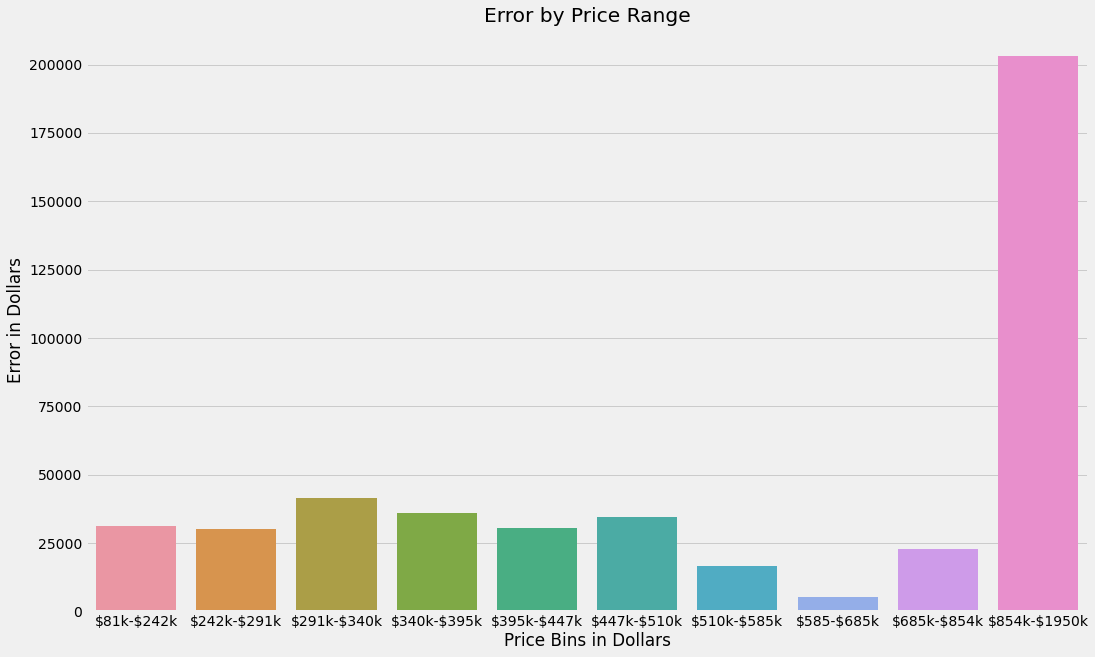

In [15]:




estimator,scaler,r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train,coefs, frame = get_scores(X)

coefficients = list(zip(X.columns,coefs))

Looking at the absolute error for each bin.

Plotting a few variables to get a sense of the relationships

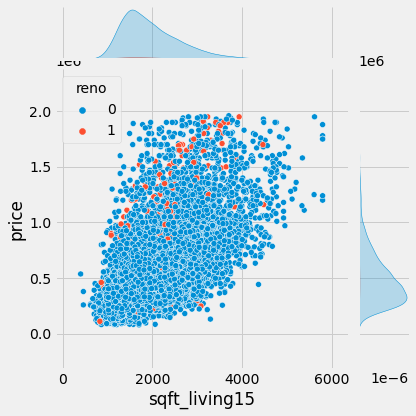

In [16]:
ax = sns.jointplot(x='sqft_living15', y="price", hue='reno',data=df);

In [20]:
frame

,error,bin_labels,mid,% error
bins,,,,
"(80999.999, 242000.0]",31186.0,\$81k-\$242k,150000,20.790667
"(242000.0, 291000.0]",30142.0,\$242k-\$291k,260000,11.593077
"(291000.0, 340000.0]",41377.0,\$291k-\$340k,320000,12.930312
"(340000.0, 394600.0]",36003.0,\$340k-\$395k,365000,9.863836
"(394600.0, 447000.0]",30432.0,\$395k-\$447k,425000,7.160471
"(447000.0, 510000.0]",34337.0,\$447k-\$510k,470000,7.305745
"(510000.0, 585000.0]",16582.0,\$510k-\$585k,550000,3.014909
"(585000.0, 685180.0]",5359.0,\$585-\$685k,630000,0.850635
"(685180.0, 854200.0]",22612.0,\$685k-\$854k,730000,3.097534


Plotting the coefficients used in the model so that the weakest ones can be removed.

            feature         import
6        sqft_lot15   11452.803944
13             reno   12030.213951
10       waterfront   12208.069266
3               lat   13586.462034
12        condition   25029.723664
0          sqft_lot   28718.804744
9          bedrooms   29407.086883
7      bathrooms_sq   30318.893246
14    median_by_zip   33951.535886
4              long   37431.081399
11             view   40571.609476
5     sqft_living15   55307.545836
2     sqft_basement   76244.315490
8      int_WFlivgrd  146859.812418
1   sqrt_sqft_above  200934.617335


C:\Users\umbac\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


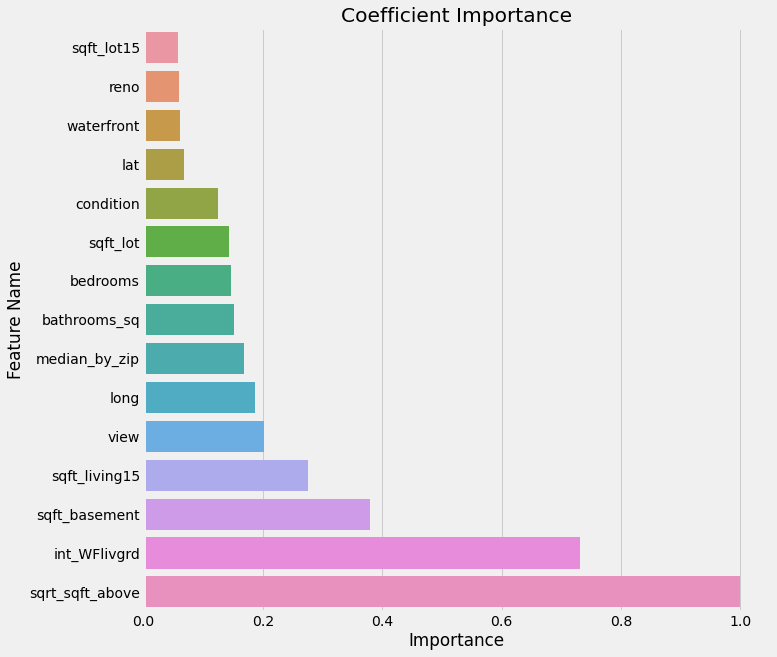

In [18]:
coef_hist = pd.DataFrame(coefficients)
coef_hist.columns = ['feature','import']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,10))
coef_hist['import'] = abs(coef_hist['import'])
coef_hist = coef_hist.sort_values(by='import')
print(coef_hist)

from sklearn.preprocessing import MaxAbsScaler
coef_hist['import'] = MaxAbsScaler().fit_transform(coef_hist[['import']])



y = coef_hist['import']
labels = coef_hist['feature']
ax = sns.barplot('import','feature',data=coef_hist)
plt.xticks(rotation=0);
plt.title('Coefficient Importance');
plt.ylabel('Feature Name')
plt.xlabel('Importance',labelpad=3)

plt.savefig('coefimport.png')
